# Universidad Nacional de Colombia
## Validacion de Clustering
### Mineria de datos
#### Alejandro Cano


## Validación K-means

En este caso práctico continuaremos con el caso de clustering que hicimos la clase anterior. Haremos la validación de nuestra aplicación de k-means.

El caso estará estructurado así
1. Resumir el caso anterior
2. Ajustar y comparar distintos k-means
3. Revisar criterios de validación
4. Hacer conclusiones a partir del análisis

**Contexto:** Las competencias deportivas cada día recogen una gran cantidad de datos relacionados con el desempeño de sus equipos y jugadores para encontrar patrones en estos datos y tomar decisiones informadas basadas en ellos. De esta manera la competencia aumenta tanto dentro como fuera de la cancha

**Problema de negocio:** Se tienen los datos de desempeño de los equipos de baloncesto del torneo NCAA March Madness que contiene las estadísticas de juego de 353 equipos de la liga. El objetivo es inspeccionar esta data utilizando técnicas de visualización y agrupación para encontrar patrones en el desempeño de los equipos y generar recomendaciones de umbrales en las estadísticas para que un equipo esté en el grupo de desempeño superior.

In [1]:
# librerías
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# display setting Para visualizar el máximo de columnas
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
datos = pd.read_csv('../Datos/basketball_19.csv')

Estas son las variables que contiene el conjunto de datos 

- TEAM: Equipo
- CONF: La conferencia en la que el equipo participa(A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)
- G: Número de partidos jugados
- W: Número de partidos ganados
- ADJOE: Estimación de eficiencia ofensiva, puntos anotados por cada 100 posesiones
- ADJDE: Estimación de eficiencia defensiva, puntos permitidos por cada 100 posesiones del equipo contrario
- BARTHAG: Probabilidad de vencer a un equipo
- EFG_O: Effective Field Goal Percentage Shot
- EFG_D: Effective Field Goal Percentage Allowed
- TOR: Porcentaje de rotación permitida (equipo pierde la posesión del balón contra el equipo contrario antes de que un jugador dispare a la canasta de su equipo)
- TORD: Porcentaje de rotación hecha al equipo contrario (se roba la pelota al contrincante)
- ORB: Porcentaje de rebote ofensivo
- B: Porcentaje de rebote defensivo
- FTR : Tasa de tiros libres hechos(que hace el equipo)
- FTRD: Tasa de tiros libres permitidos (que hace el contrincante)
- 2P_O: Porcentaje de tiros de 2 puntos hechos
- 2P_D: Porcentaje de tiros de 2 puntos permitidos
- 3P_O: Porcentaje de tiros de 3 puntos hechos
- 3P_D: Porcentaje de tiros de 3 puntos permitidos
- ADJ_T: Posesión del balón por 40 min
- WAB: Triunfos por encima de la 'burbuja' (la burbuja es el límite definido para pasar al campeonato NCAA March Madness Tournament
- POSTSEASON: Ronda en la que el equipo de fue eliminado (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)
- SEED: Semilla definida por el torneo


In [4]:
datos.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED
0,Gonzaga,WCC,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,19.0,31.5,26.8,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0,E8,1.0
1,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1.0
2,Duke,ACC,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1.0
3,North Carolina,ACC,36,29,120.1,91.4,0.9582,52.9,48.9,17.2,18.3,35.3,22.8,30.2,28.4,52.1,47.9,36.2,33.5,76.0,10.0,S16,1.0
4,Michigan,B10,37,30,114.6,85.6,0.9665,51.6,44.1,13.9,18.0,24.7,24.8,27.5,24.1,51.8,44.3,34.2,29.1,65.9,9.2,S16,2.0


## Exploración de los datos 

En el caso pasado hicimos una exploración general de las variables 

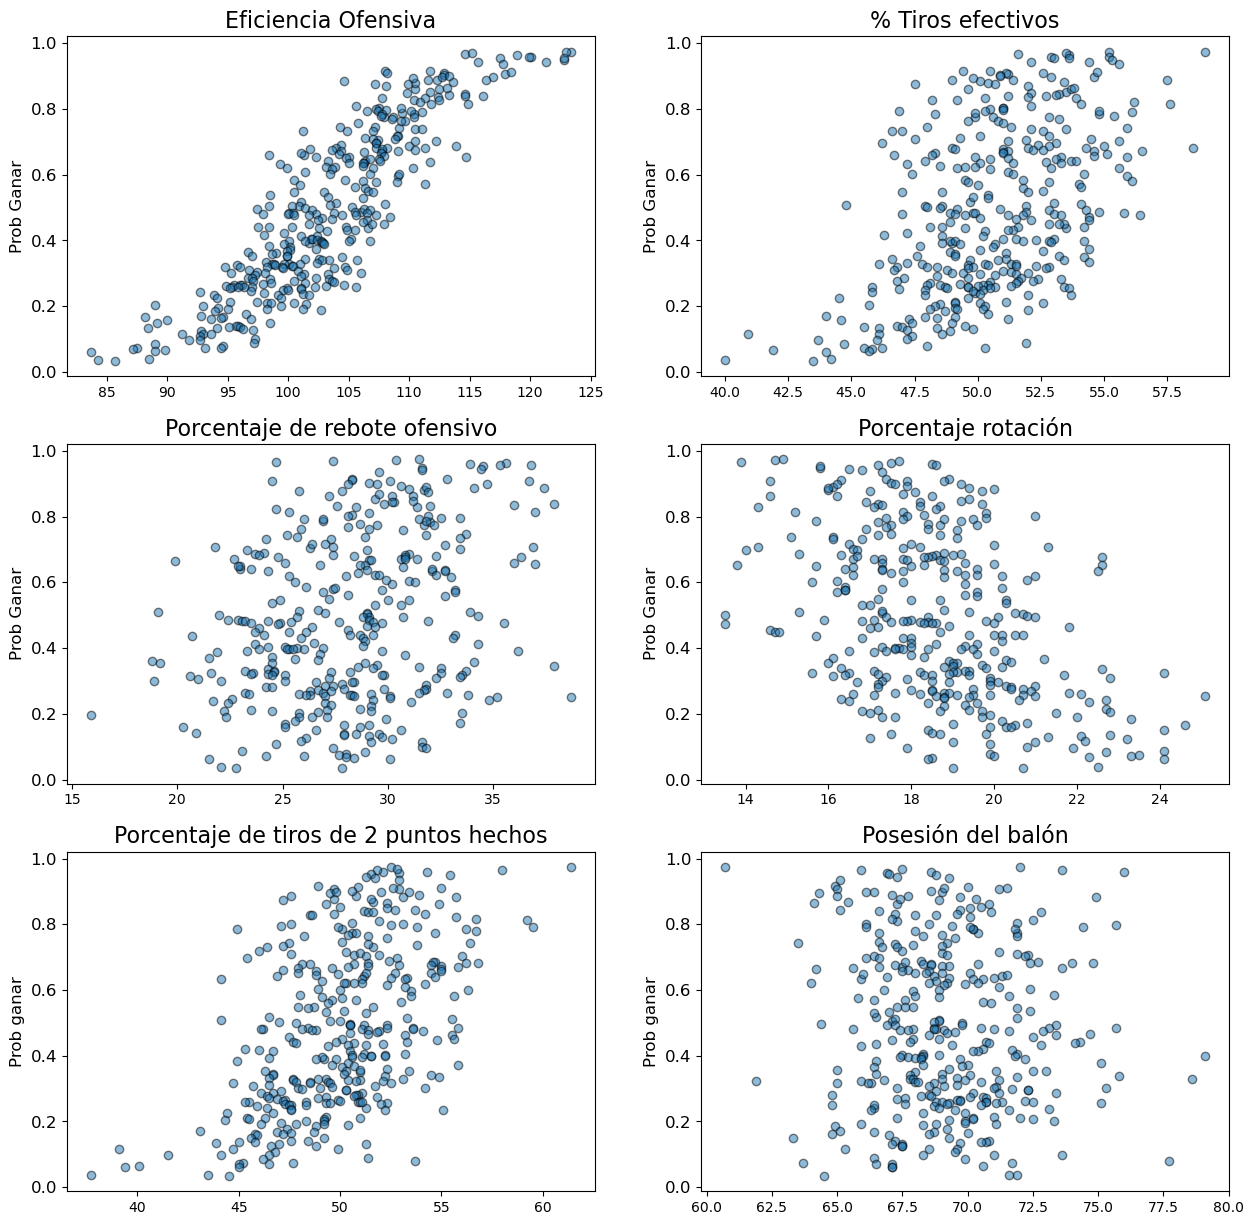

In [5]:
# Partidos jugados
plt.figure(figsize=(15,15))

plt.subplot(321)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Eficiencia Ofensiva', fontsize=16)

plt.subplot(322)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% Tiros efectivos', fontsize=16)


plt.subplot(323)
plt.scatter(y=datos['BARTHAG'], x=datos['ORB'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Porcentaje de rebote ofensivo', fontsize=16)


# Partidos ganados
plt.subplot(324)
plt.scatter(y=datos['BARTHAG'], x=datos['TOR'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob Ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Porcentaje rotación', fontsize=16)


plt.subplot(325)
plt.scatter(y=datos['BARTHAG'], x=datos['2P_O'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Porcentaje de tiros de 2 puntos hechos', fontsize=16)


plt.subplot(326)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJ_T'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Posesión del balón', fontsize=16)


plt.show()

Con ésta exploración inicial seleccionamos algunas variables para hacer el análisis de clusters

In [7]:
datos.columns

Index(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'POSTSEASON', 'SEED'],
      dtype='object')

In [6]:
# sacamos del análisis variables categóricas
km_data = datos.drop(['TEAM','CONF','POSTSEASON','SEED'],axis=1)

In [8]:
# seleccionamos las variables para el análisis
km = km_data[['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']]
km.head()

,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
0,33,123.4,0.9744,59.0,61.4,7.0
1,35,123.0,0.9736,55.2,52.5,11.1
2,32,118.9,0.9646,53.6,58.0,11.2
3,29,120.1,0.9582,52.9,52.1,10.0
4,30,114.6,0.9665,51.6,51.8,9.2


## Agrupamiento 

Al igual que en ACP es importante estandarizar las variables que vamos a utilizar. La función **StandardScaler** nos permite hacerlo en una sola linea

In [9]:
scaler = StandardScaler()
km_scale = scaler.fit_transform(km)

En el caso anterior definimos el número de clusters como $k=3$ para el algortimo de kmeans. Al ajustar el agrupamiento jerárquico observabamos que otros posibles números de cluster podríamos utilizar 

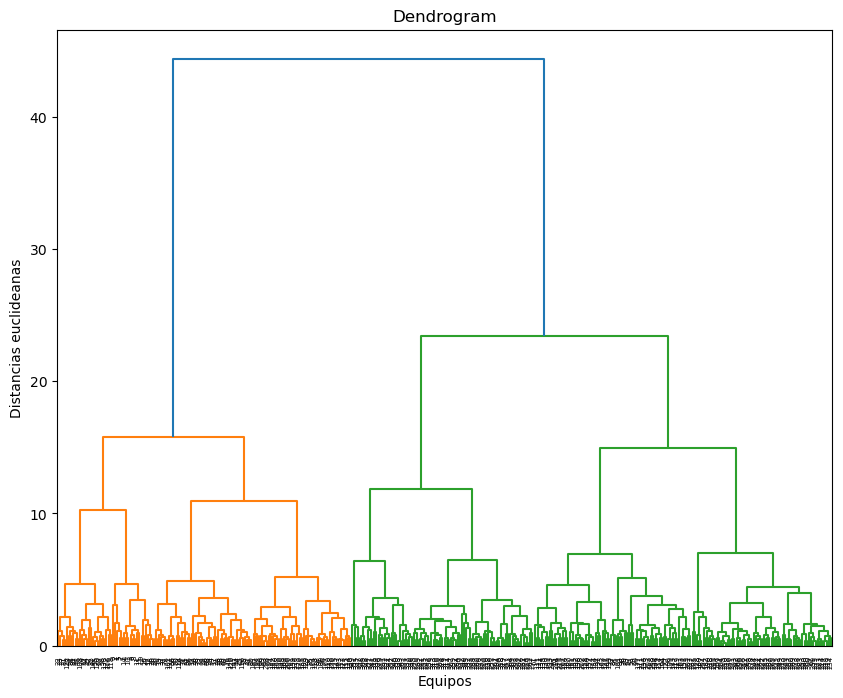

In [10]:
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(sch.linkage(km_scale, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Equipos')
plt.ylabel('Distancias euclideanas')
plt.show()

Podemos entonces ajustar el kmeans con $k=3$. Adicionalmente, tiene mucha lógica ajustarlo con $k=4$ o $k=5$

In [11]:
kmeans_3k = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=2022)
kmeans_3k.fit(km_scale)

KMeans(init='random', n_clusters=3, random_state=2022)

In [12]:
kmeans_4k = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=2022)
kmeans_4k.fit(km_scale)

KMeans(init='random', n_clusters=4, random_state=2022)

## Validación

Emplearemos validación interna para comparar las soluciones anteriores. Para esto podemos evaluar la **cohesión** revisando el argumento **inertia_** que es la suma de distancias cuadradas de cada punto a su centroide

In [13]:
print(kmeans_3k.inertia_)

804.8894012533925


In [14]:
print(kmeans_4k.inertia_)

677.0215602311466


Recordemos que entre menor sea esta suma de cuadrados será mejor la solución. Sin embargo siempre que se generen más clusters este número tiende a disminuir. Por esta razón debemos enocontrar un punto de balance entre tener un número bajo de inertia_ y un número adecuado de clusters

Podemos también revisar los coeficientes de silhouette para ver qué tan bien asignado está cada punto a su cluster

In [15]:
score = silhouette_score(km_scale, kmeans_3k.labels_)
print('Silhouetter Score 3 clusters: %.3f' % score)

Silhouetter Score 3 clusters: 0.305


In [17]:
score = silhouette_score(km_scale, kmeans_4k.labels_)
print('Silhouetter Score 4 clusters: %.3f' % score)

Silhouetter Score 4 clusters: 0.286


In [18]:
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 3, the average silhouette_score is 0.3045386246164058.


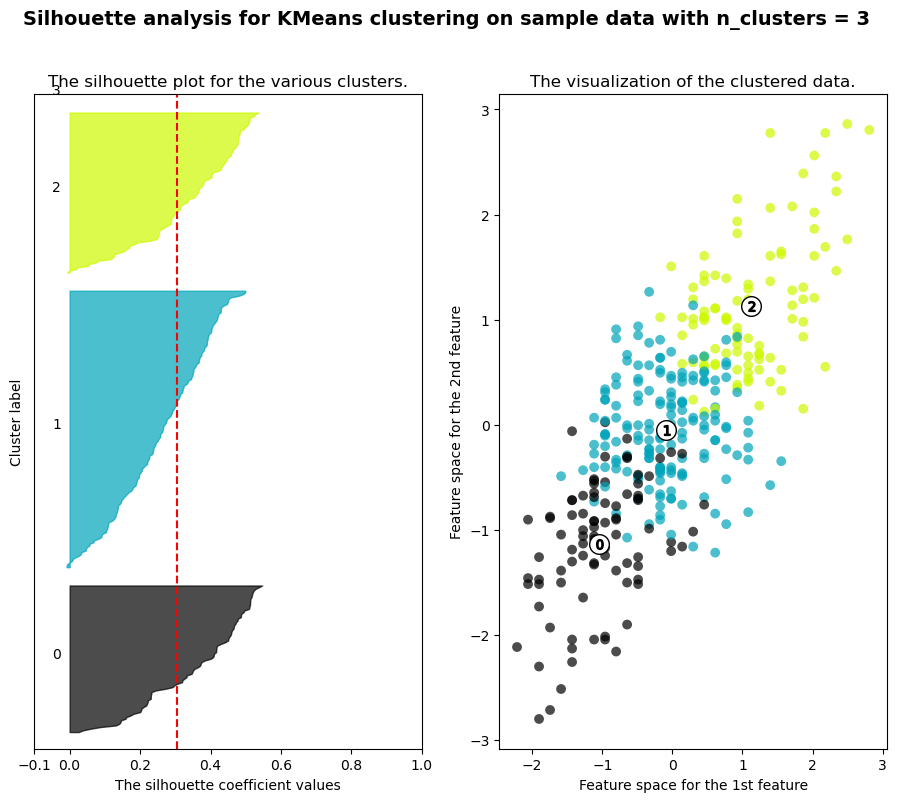

In [19]:
silplot(km_scale, kmeans_3k)

Con 4 clusters

In [20]:
score = silhouette_score(km_scale, kmeans_4k.labels_)
print('Silhouetter Score 4 clusters: %.3f' % score)

Silhouetter Score 4 clusters: 0.286


For n_clusters = 4, the average silhouette_score is 0.2857066599825597.


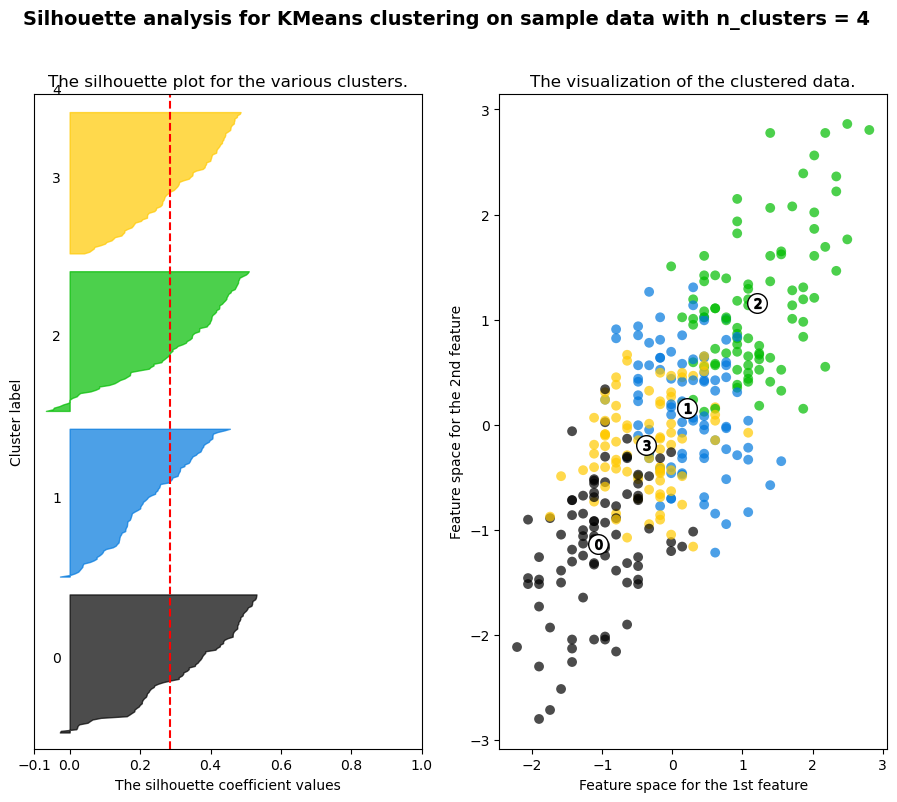

In [21]:
silplot(km_scale, kmeans_4k)

Hay menor número de puntos "mal representados" en la solución de 3 clusters

## Elección de k

Utilizaremos la comparación de valores de suma de cuadrados dentro total con respecto a diferentes valores de $k$. Este método es conocido como el **método del codo**

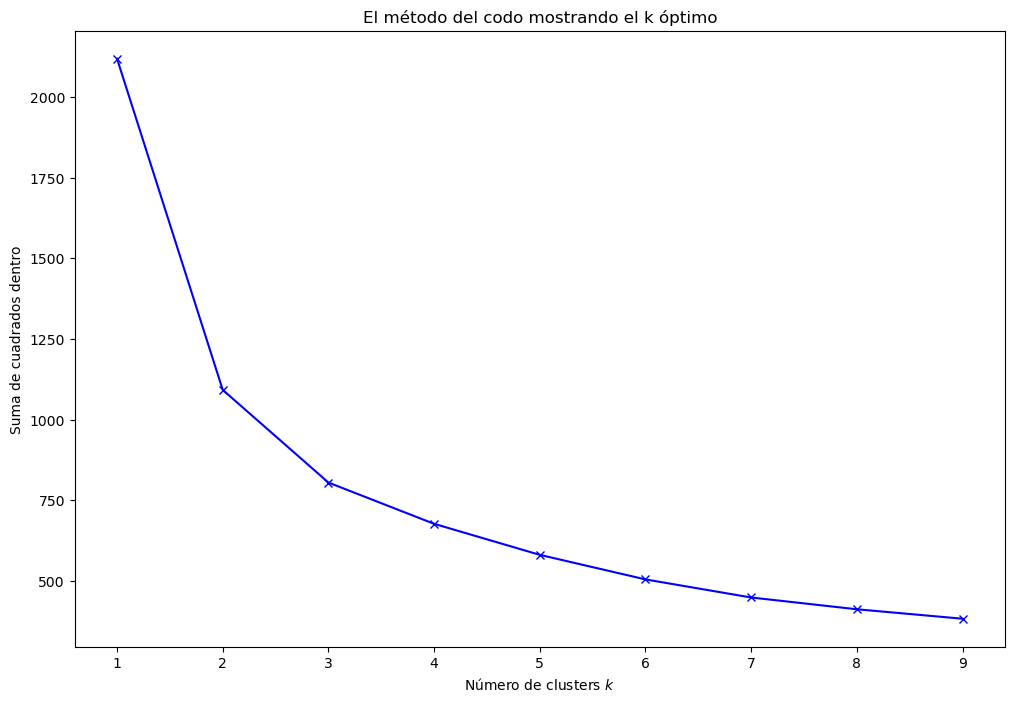

In [22]:
ssw = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init="random",n_init=10,max_iter=300,random_state=42)
    kmeanModel.fit(km_scale)
    ssw.append(kmeanModel.inertia_)
    
plt.figure(figsize=(12,8))
plt.plot(K, ssw, 'bx-')
plt.xlabel('Número de clusters $k$')
plt.ylabel('Suma de cuadrados dentro')
plt.title('El método del codo mostrando el k óptimo')
plt.show()

## ¿ Cuál consideran sería el valor óptimo para k según el método del codo?

Adicionalmente, podemos revisar el coeficiente de Silhouette

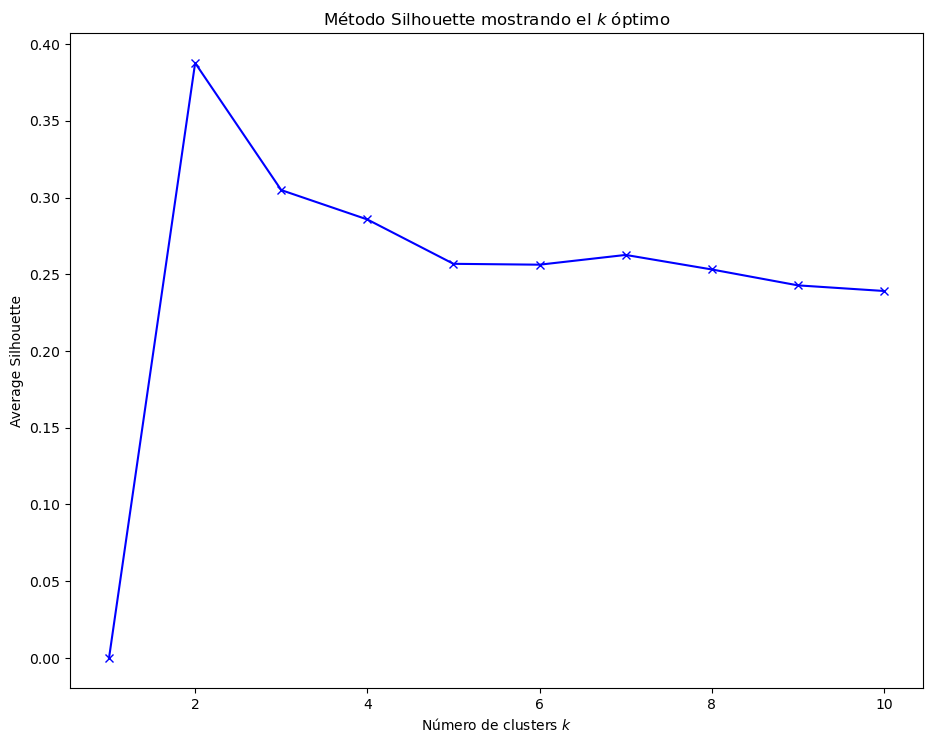

In [23]:
scores = [0]
for k in range(2,11):
    fitx = KMeans(n_clusters=k,init="random",n_init=10,max_iter=300,random_state=42).fit(km_scale)
    score = silhouette_score(km_scale, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Número de clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('Método Silhouette mostrando el $k$ óptimo')
plt.show()

## ¿Cuál consideran sería el valor óptimo para k según el método de silhouette?

No necesariamente los métodos deben coincidir ni dan una única respuesta. Depende del investigador y el contexto analizar qué solución podría ser mejor

## Validación estructura de clusters

Podemos guardar los clusters asignados por el algoritmo cuando se usaron $k=3$ y $k=4$ y evaluar las diferencias entre ellos en cómo están definidos en la data

In [24]:
datos['cluster_3k'] = kmeans_3k.labels_
datos['cluster_4k'] = kmeans_4k.labels_

Revisemos la distribución de estos clusters

1    167
2     97
0     89
Name: cluster_3k, dtype: int64


<AxesSubplot: >

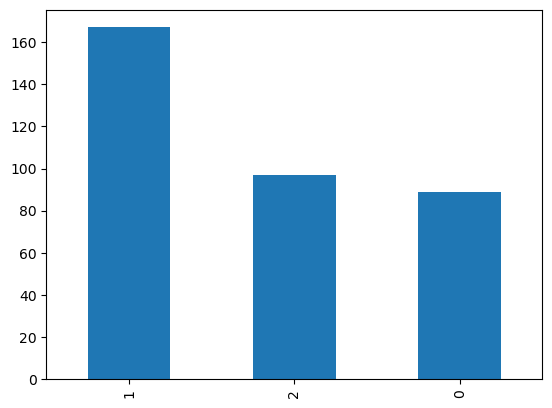

In [25]:
print(datos.cluster_3k.value_counts())
datos.cluster_3k.value_counts().plot(kind='bar')

1    92
3    88
2    87
0    86
Name: cluster_4k, dtype: int64


<AxesSubplot: >

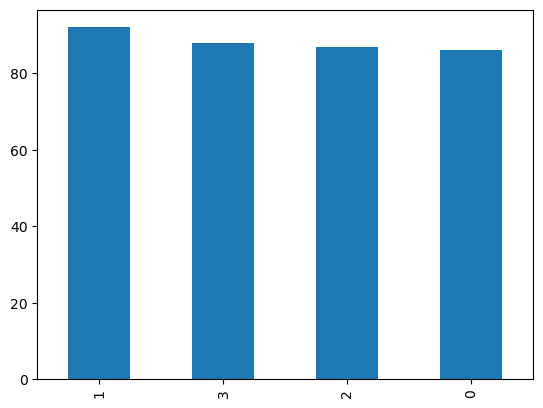

In [26]:
print(datos.cluster_4k.value_counts())
datos.cluster_4k.value_counts().plot(kind='bar')

Para tener mayor información podríamos visualizar las variables originales de acuerdo a los clusters para entender mejor la estructura

**Solución 3 clusters**

Text(0.5, 1.0, '% Tiros efectivos')

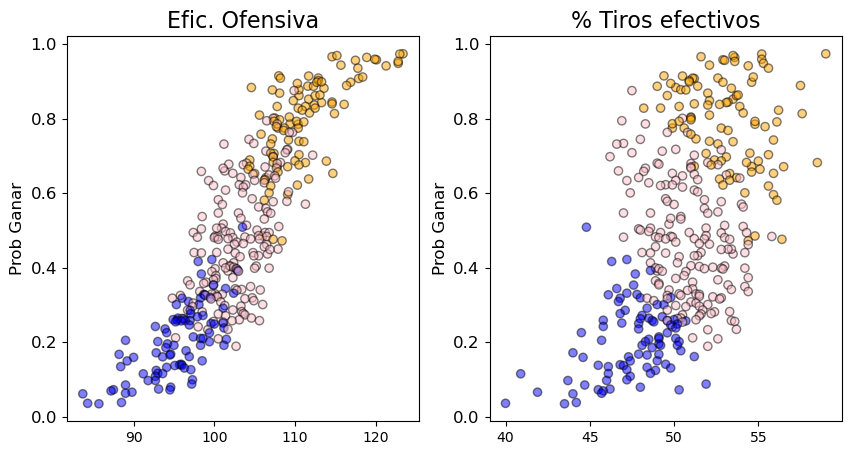

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(121)
colors ={0: 'blue', 1: 'pink', 2: 'orange' , 3:'green', 4:'red'}
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],c=datos['cluster_3k'].apply(lambda x: colors[x]),alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Efic. Ofensiva', fontsize=16)

plt.subplot(122)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],c=datos['cluster_3k'].apply(lambda x: colors[x]),alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% Tiros efectivos', fontsize=16)


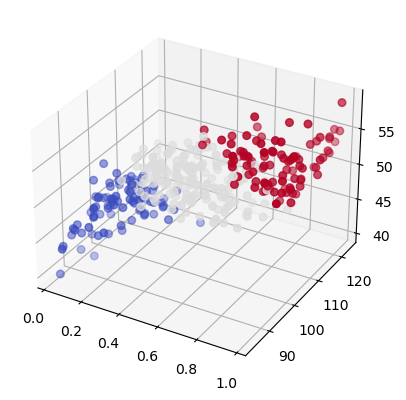

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p3d = ax.scatter(xs=datos['BARTHAG'], ys=datos['ADJOE'], zs=datos['EFG_O'], s=30, c=datos['cluster_3k'], cmap = cm.coolwarm)
plt.show()

**Solución 4 clusters**

Text(0.5, 1.0, '% Tiros efectivos')

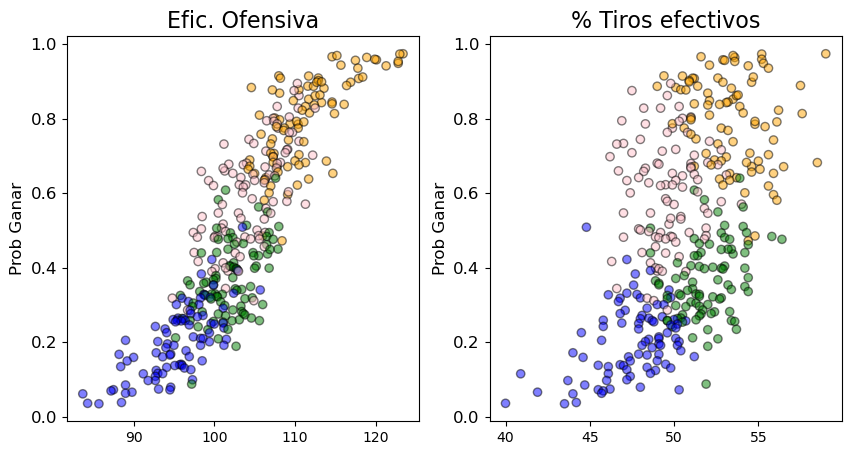

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(121)
colors ={0: 'blue', 1: 'pink', 2: 'orange' , 3:'green', 4:'red'}
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],c=datos['cluster_4k'].apply(lambda x: colors[x]),alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Efic. Ofensiva', fontsize=16)

plt.subplot(122)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],c=datos['cluster_4k'].apply(lambda x: colors[x]),alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% Tiros efectivos', fontsize=16)

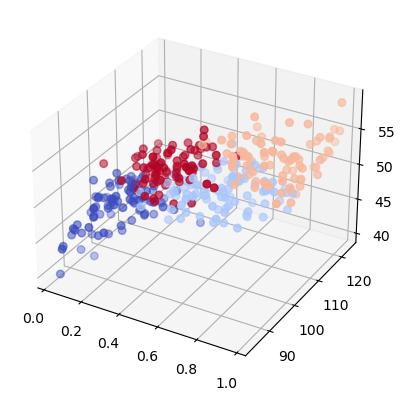

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p3d = ax.scatter(xs=datos['BARTHAG'], ys=datos['ADJOE'], zs=datos['EFG_O'], s=30, c=datos['cluster_4k'], cmap = cm.coolwarm)
plt.show()

In [31]:
pd.crosstab(datos['cluster_3k'],datos['cluster_4k'])

cluster_4k,0,1,2,3
cluster_3k,,,,
0,85,2,0,2
1,1,81,0,85
2,0,9,87,1


En los anteriores gráficos se observa cómo claramente al aumentar el número de clusters, el nuevo grupo se traslapa con los anteriores. Esta situación podría llevar a una solución redundante donde dos clusters van a tener características muy similares o cercanas. Revisemos la caracterización de los clusters con las variables numéricas

In [32]:
datos.groupby('cluster_3k')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()

/var/folders/c2/8tj5whlx71x5y8xdcjpgmgmm0000gn/T/ipykernel_12222/857408308.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datos.groupby('cluster_3k')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()


,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
cluster_3k,,,,,,
0,10.483146,95.362921,0.203734,47.512360,46.525843,-15.464045
1,16.491018,102.996407,0.471995,50.779641,50.290419,-8.817365
2,24.268041,111.236082,0.795351,53.126804,52.906186,1.043299


In [33]:
datos[['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']].mean()

W           17.113314
ADJOE      103.335977
BARTHAG      0.493214
EFG_O       50.600850
2P_O        50.060057
WAB         -7.783569
dtype: float64

In [34]:
datos.groupby('cluster_4k')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()

/var/folders/c2/8tj5whlx71x5y8xdcjpgmgmm0000gn/T/ipykernel_12222/934414314.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datos.groupby('cluster_4k')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()


,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
cluster_4k,,,,,,
0,10.325581,95.341860,0.201931,47.487209,46.423256,-15.547674
1,18.434783,104.425000,0.599246,49.580435,48.966304,-5.653261
2,24.839080,111.448276,0.796714,53.408046,53.240230,1.255172
3,14.727273,101.989773,0.366974,51.935227,51.613636,-11.359091


En la solución de 4 clusters se puede ver como el cluster de nivel medio en la solución original es ahora reemplazado por dos clusters que podríamos considerar de desempeño medio-bajo (1) y medio-alto (2)

## Comparación ACP y Kmeans

Ajustamos un ACP con las variables de interés

In [35]:
pca = PCA(n_components=5)
pca_bs = pca.fit(km_scale)
pca_bs = pca.transform(km_scale)

In [36]:
pca.components_[0]

array([0.4172686 , 0.4360787 , 0.42392345, 0.37002618, 0.363898  ,
       0.43205331])

Revisemos cuántos componentes deberíamos utilizar

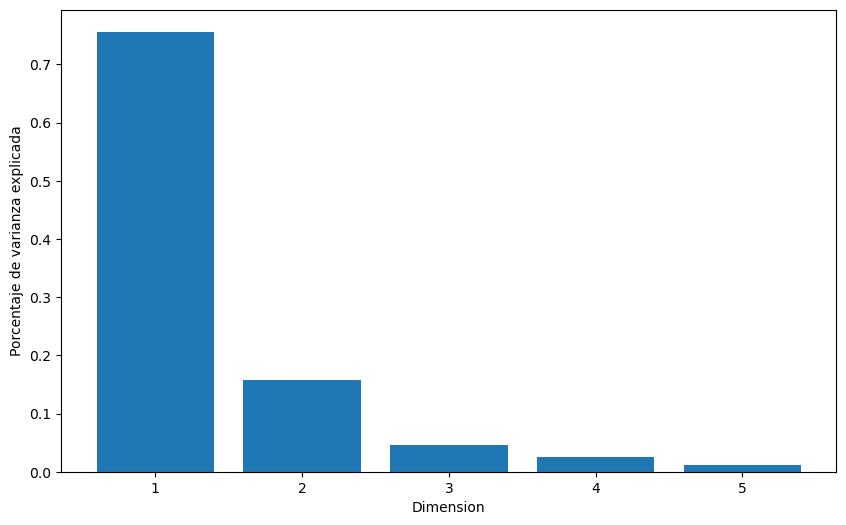

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(np.array([1,2,3,4,5]),pca.explained_variance_ratio_)
ax.set(xlabel = "Dimension",
       ylabel = "Porcentaje de varianza explicada")
plt.show()

In [38]:
principalDf = pd.DataFrame(data = pca_bs, columns = ['PC1', 'PC2','PC3', 'PC4','PC5'])
principalDf.head()

,PC1,PC2,PC3,PC4,PC5
0,6.283119,1.473149,-0.109313,0.073790,0.540570
1,5.193488,-1.122277,-0.209196,-0.978073,0.390879
2,5.127032,-0.322164,-0.380312,0.673238,0.747312
3,4.193757,-1.337551,0.245965,-0.325856,0.388992
4,3.686043,-1.591574,-0.292966,0.075627,0.142099


In [39]:
datos['CP1'] = principalDf['PC1']
datos['CP2'] = principalDf['PC2']
datos['CP3'] = principalDf['PC3']

Evaluemos cuántos clusters deberíamos tener con estas nuevas variables 

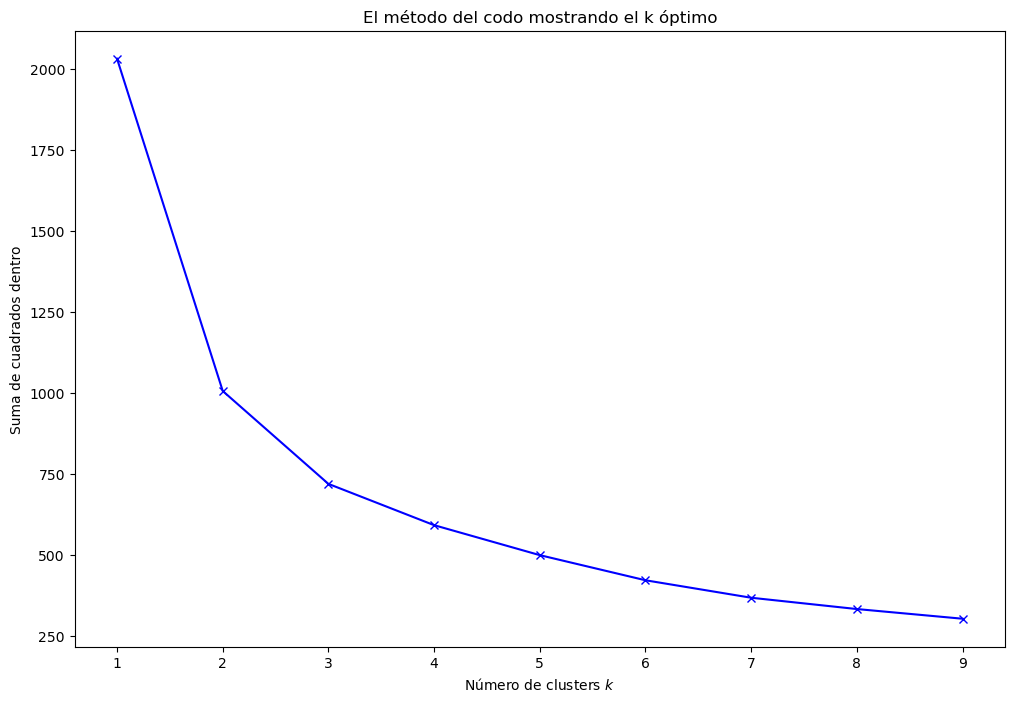

In [40]:
ssw = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init="random",n_init=10,max_iter=300,random_state=42)
    kmeanModel.fit(datos[['CP1','CP2','CP3']])
    ssw.append(kmeanModel.inertia_)
    
plt.figure(figsize=(12,8))
plt.plot(K, ssw, 'bx-')
plt.xlabel('Número de clusters $k$')
plt.ylabel('Suma de cuadrados dentro')
plt.title('El método del codo mostrando el k óptimo')
plt.show()

Nuevamente parece que k=4 podría ser un valor apropiado para el número de clusters

In [41]:
kmeans_acp = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=42)
kmeans_acp.fit(datos[['CP1','CP2','CP3']])

KMeans(init='random', n_clusters=4, random_state=42)

**Comparación de resultados**

Cohesión 

In [42]:
print(kmeans_acp.inertia_)
print(kmeans_4k.inertia_)

591.0943234358351
677.0215602311466


Silhouette

In [43]:
score = silhouette_score(datos[['CP1','CP2','CP3']], kmeans_acp.labels_)
print('Silhouetter Score clusters ACP: %.3f' % score)

Silhouetter Score clusters ACP: 0.317


In [44]:
score = silhouette_score(km_scale, kmeans_4k.labels_)
print('Silhouetter Score 4 clusters: %.3f' % score)

Silhouetter Score 4 clusters: 0.286


For n_clusters = 4, the average silhouette_score is 0.3165472112228448.


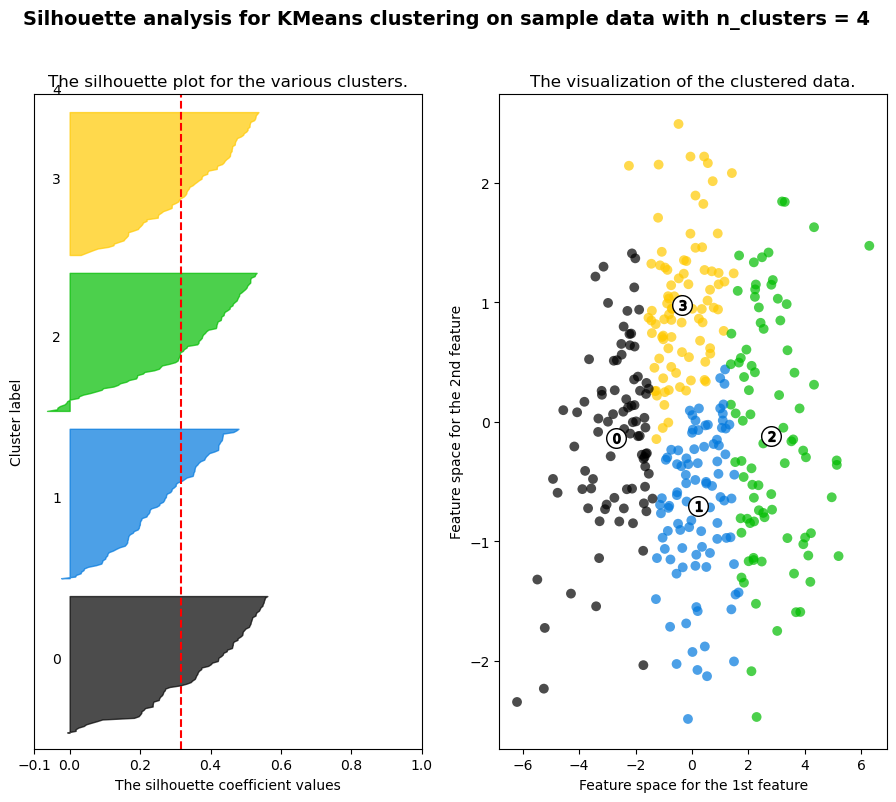

In [45]:
silplot(datos[['CP1','CP2','CP3']].values,kmeans_acp)

In [46]:
datos['cluster_acp'] = kmeans_acp.labels_

1    93
3    89
2    86
0    85
Name: cluster_acp, dtype: int64


<AxesSubplot: >

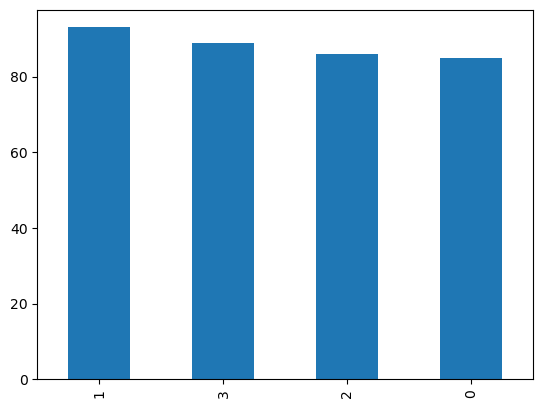

In [47]:
print(datos.cluster_acp.value_counts())
datos.cluster_acp.value_counts().plot(kind='bar')

In [48]:
pd.crosstab(datos['cluster_4k'],datos['cluster_acp'])

cluster_acp,0,1,2,3
cluster_4k,,,,
0,85,0,0,1
1,0,92,0,0
2,0,1,86,0
3,0,0,0,88


Text(0.5, 1.0, '% Tiros efectivos')

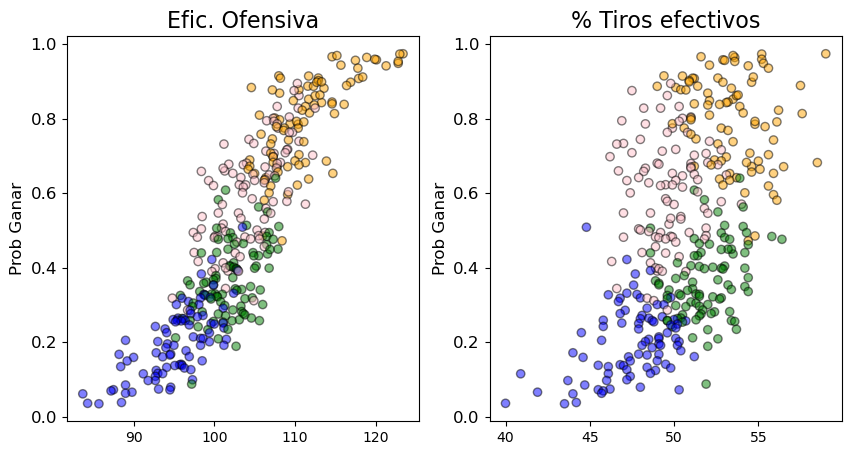

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(121)
colors ={0: 'blue', 1: 'pink', 2: 'orange' , 3:'green', 4:'red'}
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],c=datos['cluster_acp'].apply(lambda x: colors[x]),alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Efic. Ofensiva', fontsize=16)

plt.subplot(122)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],c=datos['cluster_acp'].apply(lambda x: colors[x]),alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% Tiros efectivos', fontsize=16)

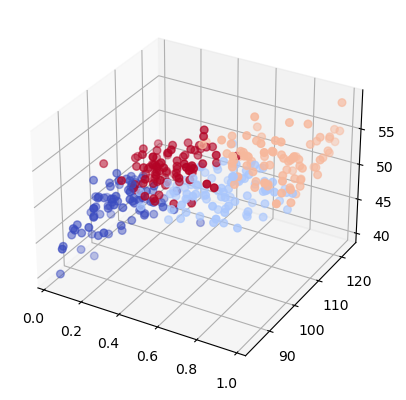

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p3d = ax.scatter(xs=datos['BARTHAG'], ys=datos['ADJOE'], zs=datos['EFG_O'], s=30, c=datos['cluster_acp'], cmap = cm.coolwarm)
plt.show()

## Ejercicios

1. Ajustemos un nuevo kmeans considerando ahora 5 clusters
2. ¿Qué diferencias se evidencian en comparación con los dos anteriores?
3. Analicemos la caracterización de los 5 clusters con las variables originales, ¿qué nombre le podríamos dar a cada uno de los clusters?
4. Después de analizar estas tres opciones, ¿cuál sería la mejor solución en este caso?

## Conclusiones

- Efectivamente se logran diferenciar tres grandes segmentos en los equipos: desempeño bajo, medio y alto
- Las métricas de validación son una gran herramienta para tomar la decisión sobre el número de clusters a utilizar
- También es necesario tener en cuenta el contexto de los datos para definir si la solución tiene sentido
